# Notebook to explore visual processing

Note: install seaborn:
`!pip install seaborn`

In [1]:
from flygym import Camera, Simulation
import cv2
import numpy as np
from tqdm import trange
import flygym as flygym
from flygym.arena import FlatTerrain
from flygym.preprogrammed import all_leg_dofs
from flygym.vision import save_video_with_vision_insets

In [2]:
from scripts.utils import plot_chasing
from scripts.hybrid_turning_fly import HybridTurningFly
from scripts.chasing_fly import ChasingFly
from scripts.colored_terrain import FlatTerrainColored

## Define parameters for simulation

General parameters

In [3]:
timestep = 1e-4
run_time = 1
t = np.arange(0, run_time, timestep)

Flies

In [4]:
fly1 = HybridTurningFly(
    name="1",
    timestep=timestep,
    enable_adhesion=True,
    spawn_pos=(6, 2, 0.5),
)

fly0 = ChasingFly(
    name="0",
    other_fly=fly1,
    desired_distance=0.02,
    timestep=timestep,
    enable_adhesion=True,
    head_stabilization_model="thorax",
    neck_kp=1000,
)

Arena

In [5]:
arena = FlatTerrain()

Cameras

In [6]:
birdeye_cam_zoom = arena.root_element.worldbody.add(
    "camera",
    name="birdeye_cam_zoom",
    mode="fixed",
    pos=(15, 0, 20), 
    euler=(0, 0, 0),
    fovy=45,
)

birdeye_cam = arena.root_element.worldbody.add(
    "camera",
    name="birdeye_cam",
    mode="fixed",
    pos=(15, 0, 35),
    euler=(0, 0, 0),
    fovy=45,
)

cam = Camera(
    fly=fly0,
    camera_id="birdeye_cam",
    play_speed=0.5,
    window_size=(800, 608),
)

Simulation

In [7]:
sim = Simulation(
    flies=[fly0, fly1],
    cameras=[cam],
    arena=arena,
    timestep=timestep,
)

Target fly actions

In [8]:
# Define fly 1 actions --> sinusoidal trajectory
speed_variation = np.abs(np.sin(t * np.pi / 2))
fly1_actions = np.zeros((len(t), 2))  
'''
# Create the fly 1 actions scenario
for i, time in enumerate(t):
    if time < (1/3) * run_time:
        # sinusoidal trajectory for the first 1/3 of the time
        fly1_actions[i] = (
            np.abs(np.cos(time * np.pi / 2)) * speed_variation[i],
            np.abs(np.sin(time * np.pi / 2)) * speed_variation[i],
        ) 
    elif time < (2/3) * run_time:
        # stop for the second 1/3 of the time
        fly1_actions[i] = (0, 0)
    else:
        # sinusoidal trajectory for the last 1/3 of the time
        fly1_actions[i] = (
            np.abs(np.cos(time * np.pi / 2)) * speed_variation[i],
            np.abs(np.sin(time * np.pi / 2)) * speed_variation[i],
        )
'''
# Modifiy fly speed
mean_speed = 1.2  
std_dev_speed = 0.4  

# fly1_actions *= random_speed_variation
#fly1_actions = np.clip(fly1_actions, 0, 2 * mean_speed)

## Explore chasing and visual processing

### Run stimulation

In [10]:
# Reset the simulation and set fly 1 to be black
sim.reset(seed=0)
for i in fly1.model.find_all("geom"):
    sim.physics.named.model.geom_rgba[f"1/{i.name}"] = (0, 0, 0, 1)

# Prepare simulation
second_cam_frames = []
fly0_action = np.zeros(2)
x = None
alpha = 1e-1

# Prepare variables to plot 
proximities = []
speeds_fly0 = []
speeds_fly1 = []

# Run simulation for each timepoint
for i in trange(len(t)):
    obs, _, _, _, info = sim.step(
        {
            "0": fly0_action,
            "1": fly1_actions[i],
        
        }
    )

    # Get observations for fly 0
    obs0, info0 = obs["0"], info["0"]
    render_res = sim.render()[0]
    velocity0 = obs0["fly"][1]
    v0 = np.linalg.norm(velocity0)

    # Get observations for fly 1
    obs1, info1 = obs["1"], info["1"]
    velocity1 = obs1["fly"][1]
    v1 = np.linalg.norm(velocity1)

    # If frame is rendered, save it
    if render_res is not None:
        fly0.visual_inputs_hist.append(obs0["vision"].copy())
        second_cam = sim.physics.bind(birdeye_cam_zoom)

        x_new = sim._get_center_of_mass()[0]

        if x is None:
            x = x_new

        x = (1 - alpha) * x + alpha * x_new

        second_cam.pos[0] = x
        second_img = sim.physics.render(
            width=700, height=560, camera_id="birdeye_cam_zoom"
        )
        second_img = cv2.putText(
            np.ascontiguousarray(second_img),
            f"{sim.cameras[0].play_speed}x",
            org=(20, 30),
            fontFace=cv2.FONT_HERSHEY_DUPLEX,
            fontScale=0.8,
            color=(0, 0, 0),
            lineType=cv2.LINE_AA,
            thickness=1,
        )
        second_cam_frames.append(second_img)

    # Process visual input for fly 0
    visual_features, proximity = fly0.process_visual_observation(obs0["vision"])
    left_deviation = 1 - visual_features[1]
    right_deviation = visual_features[4]
    left_found = visual_features[2] > 0.005
    right_found = visual_features[5] > 0.005

    if not left_found:
        left_deviation = np.nan

    if not right_found:
        right_deviation = np.nan

    # Calculate fly 0 action
    fly0_action = np.array(
        [
            fly0.calc_ipsilateral_speed(left_deviation, left_found),
            fly0.calc_ipsilateral_speed(right_deviation, right_found),
        ]
    )

    walking_speed = fly0.calc_walking_speed(proximity)
    fly0_action *= walking_speed

    # Save variables for plotting
    proximities.append(proximity)
    speeds_fly0.append(v0)
    speeds_fly1.append(v1)

  6%|▌         | 621/10000 [00:09<02:17, 68.09it/s]


PhysicsError: Physics state is invalid. Warning(s) raised: mjWARN_BADQACC

### Save video

In [10]:
birdeye_cam_frames = cam._frames
cam._frames = second_cam_frames
sim.fly = fly0

save_video_with_vision_insets(
    sim,
    cam,
    "outputs/fly_following_with_retina_images_crab2.mp4",
    fly0.visual_inputs_hist,
)

### Plot evolution of velocity and distance

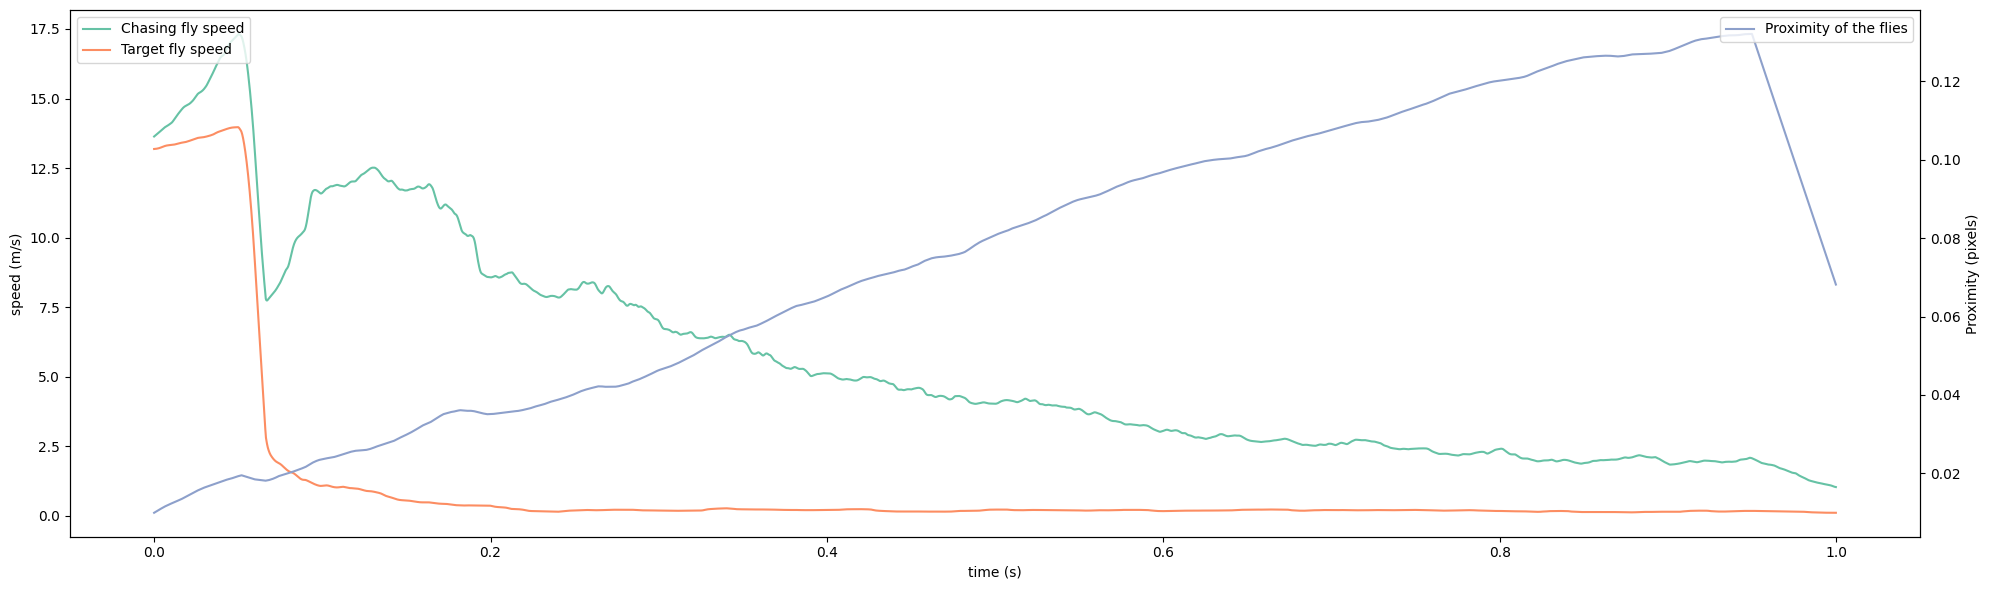

In [11]:
plot_chasing(t, speeds_fly0, speeds_fly1, proximities)

## Change parameters of stimulation to test robustness

### Change fly color

In [36]:
# FIXME: Physics state is invalid. Warning(s) raised: mjWARN_BADQACC

In [15]:
# Reset the simulation
sim.reset(seed=0)

# for i in fly1.model.find_all("geom"):
#     sim.physics.named.model.geom_rgba[f"1/{i.name}"] = (0, 0, 0, 1)

# Prepare simulation
second_cam_frames = []
fly0_action = np.zeros(2)
x = None
alpha = 1e-1

# Prepare variables to plot 
proximities = []
speeds_fly0 = []
speeds_fly1 = []

# Run simulation for each timepoint
for i in trange(len(t)):
    obs, _, _, _, info = sim.step(
        {
            "0": fly0_action,
            "1": fly1_actions[i],
        }
    )

    # Get observations for fly 0
    obs0, info0 = obs["0"], info["0"]
    render_res = sim.render()[0]
    velocity0 = obs0["fly"][1]
    v0 = np.linalg.norm(velocity0)

    # Get observations for fly 1
    obs1, info1 = obs["1"], info["1"]
    velocity1 = obs1["fly"][1]
    v1 = np.linalg.norm(velocity1)

    # If frame is rendered, save it
    if render_res is not None:
        fly0.visual_inputs_hist.append(obs0["vision"].copy())
        second_cam = sim.physics.bind(birdeye_cam_zoom)

        x_new = sim._get_center_of_mass()[0]

        if x is None:
            x = x_new

        x = (1 - alpha) * x + alpha * x_new

        second_cam.pos[0] = x
        second_img = sim.physics.render(
            width=700, height=560, camera_id="birdeye_cam_zoom"
        )
        second_img = cv2.putText(
            np.ascontiguousarray(second_img),
            f"{sim.cameras[0].play_speed}x",
            org=(20, 30),
            fontFace=cv2.FONT_HERSHEY_DUPLEX,
            fontScale=0.8,
            color=(0, 0, 0),
            lineType=cv2.LINE_AA,
            thickness=1,
        )
        second_cam_frames.append(second_img)

    # Process visual input for fly 0
    visual_features, proximity = fly0.process_visual_observation(obs0["vision"])
    left_deviation = 1 - visual_features[1]
    right_deviation = visual_features[4]
    left_found = visual_features[2] > 0.005
    right_found = visual_features[5] > 0.005

    if not left_found:
        left_deviation = np.nan

    if not right_found:
        right_deviation = np.nan

    # Calculate fly 0 action
    fly0_action = np.array(
        [
            fly0.calc_ipsilateral_speed(left_deviation, left_found),
            fly0.calc_ipsilateral_speed(right_deviation, right_found),
        ]
    )

    walking_speed = fly0.calc_walking_speed(proximity)
    fly0_action *= walking_speed

    # Save variables for plotting
    proximities.append(proximity)
    speeds_fly0.append(v0)
    speeds_fly1.append(v1)

  6%|▌         | 619/10000 [00:03<00:57, 163.98it/s]


KeyboardInterrupt: 

In [10]:
birdeye_cam_frames = cam._frames
cam._frames = second_cam_frames
sim.fly = fly0

save_video_with_vision_insets(
    sim,
    cam,
    "outputs/fly_following_with_retina_images_colors.mp4",
    fly0.visual_inputs_hist,
)

In [ ]:
len(cam._frames), len(fly0.visual_inputs_hist)

(60, 416)

In [ ]:
plot_chasing(t, speeds_fly0, speeds_fly1, proximities)

### Change ground color to black

In [ ]:
# FIXME: chasing doesn't work when ground has another color

In [ ]:
rgb1 = (1, 0.984, 0)
rgb2 = (1, 0, 0)
arena = FlatTerrainColored(rgb1=rgb1, rgb2=rgb2)

# Reset the simulation
sim.reset(seed=0)

for i in fly1.model.find_all("geom"):
    sim.physics.named.model.geom_rgba[f"1/{i.name}"] = (0, 0, 0, 1)

# Prepare simulation
second_cam_frames = []
fly0_action = np.zeros(2)
x = None
alpha = 1e-1

# Prepare variables to plot 
proximities = []
speeds_fly0 = []
speeds_fly1 = []

# Run simulation for each timepoint
for i in trange(len(t)):
    obs, _, _, _, info = sim.step(
        {
            "0": fly0_action,
            "1": fly1_actions[i],
        }
    )

    # Get observations for fly 0
    obs0, info0 = obs["0"], info["0"]
    render_res = sim.render()[0]
    velocity0 = obs0["fly"][1]
    v0 = np.linalg.norm(velocity0)

    # Get observations for fly 1
    obs1, info1 = obs["1"], info["1"]
    velocity1 = obs1["fly"][1]
    v1 = np.linalg.norm(velocity1)

    # If frame is rendered, save it
    if render_res is not None:
        fly0.visual_inputs_hist.append(obs0["vision"].copy())
        second_cam = sim.physics.bind(birdeye_cam_zoom)

        x_new = sim._get_center_of_mass()[0]

        if x is None:
            x = x_new

        x = (1 - alpha) * x + alpha * x_new

        second_cam.pos[0] = x
        second_img = sim.physics.render(
            width=700, height=560, camera_id="birdeye_cam_zoom"
        )
        second_img = cv2.putText(
            np.ascontiguousarray(second_img),
            f"{sim.cameras[0].play_speed}x",
            org=(20, 30),
            fontFace=cv2.FONT_HERSHEY_DUPLEX,
            fontScale=0.8,
            color=(0, 0, 0),
            lineType=cv2.LINE_AA,
            thickness=1,
        )
        second_cam_frames.append(second_img)

    # Process visual input for fly 0
    visual_features, proximity = fly0.process_visual_observation(obs0["vision"])
    left_deviation = 1 - visual_features[1]
    right_deviation = visual_features[4]
    left_found = visual_features[2] > 0.005
    right_found = visual_features[5] > 0.005

    if not left_found:
        left_deviation = np.nan

    if not right_found:
        right_deviation = np.nan

    # Calculate fly 0 action
    fly0_action = np.array(
        [
            fly0.calc_ipsilateral_speed(left_deviation, left_found),
            fly0.calc_ipsilateral_speed(right_deviation, right_found),
        ]
    )

    walking_speed = fly0.calc_walking_speed(proximity)
    fly0_action *= walking_speed

    # Save variables for plotting
    proximities.append(proximity)
    speeds_fly0.append(v0)
    speeds_fly1.append(v1)

100%|██████████| 30000/30000 [10:32<00:00, 47.46it/s]


In [ ]:
birdeye_cam_frames = cam._frames
cam._frames = second_cam_frames
sim.fly = fly0

save_video_with_vision_insets(
    sim,
    cam,
    "outputs/fly_following_with_retina_images.mp4",
    fly0.visual_inputs_hist,
)

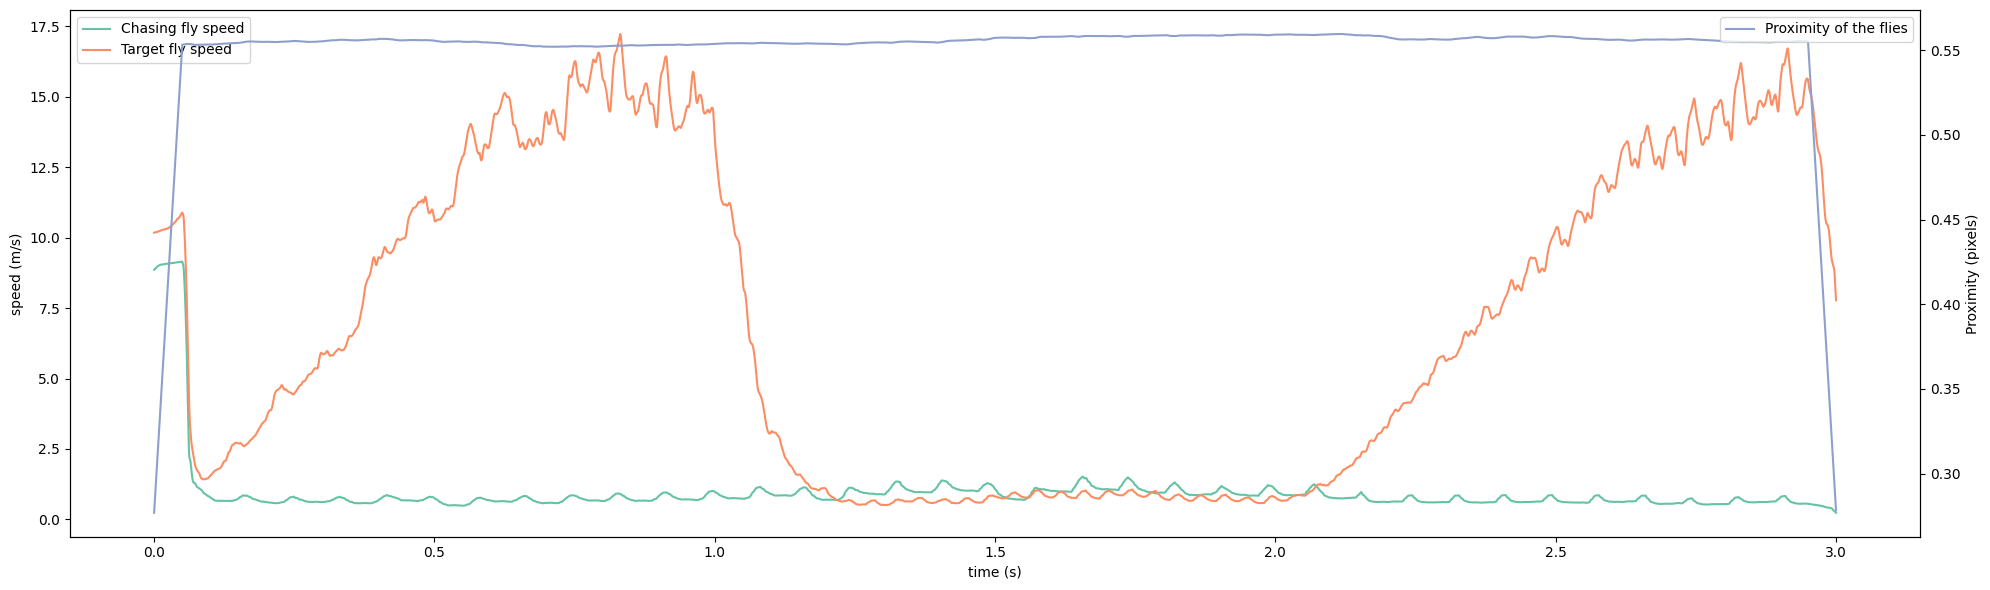

In [ ]:
plot_chasing(t, speeds_fly0, speeds_fly1, proximities)